# Backtesting 101 - Basics

First we install Yfinance, a Python package that allows us to download market data. Since we are working in Google Colab, this will be installed on Google's own server.

Next, we import some standard packages, as well as Yfinance.

In [3]:
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Now we can use yfinance to get market data for the S&P500 ETF, SPY. Without specifying any start and end dates, we we get the full dataset.

In [4]:
df = yf.download('SPY')

[*********************100%***********************]  1 of 1 completed


We can now extract different columns from the Pandas dataframe. In this case we are using the adjusted close prices. In the raw data, corportate actions such as splits and dividends can skew our results badly. Adjusting helps to avoid this and obtain more realistic simulations.

In order to create moving averages, we can use the "rolling" function for rolling windows in Pandas. You can pass the lookback window to the function and attach another function to determine what to do with this window such as mean(), std(), min(), max().

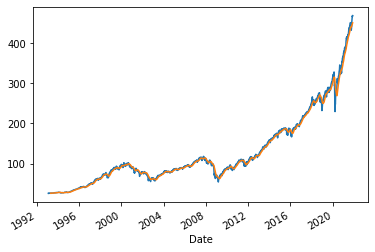

In [5]:
spy = df['Adj Close']
#spy.plot()
ma1 = spy.rolling(5).mean()
ma2 = spy.rolling(60).mean()
ma1.plot()
ma2.plot()

Now that we have pre-calculated some indicators, we can build the backtest. Notice the different elements of the backtest:
- A loop stepping through all the time steps
- Conditional statements for changes in positions
- PnL calculations upon exit of the trade
- Update of the trade state (inpos, entry, start)
- Calculation of unrealized PnL

Note that we have two separate calculations for realized and unrealized PnL. The first helps us to calculate profit-per-trade while the latter allows us to calculate the Sharpe ratio, drawdown and beta.

Notice, how the the trading cost calculation is implemented for realized and unrealized PnL.

In [6]:
pnls = []
entry = None
dates = []
unrlzd = []
unrlzd_dates = []
inpos = 0
hold_times = []
COMMS = 0.005
for i in range(len(spy)):
  unr = ((spy.iloc[i]-spy.iloc[i-1])/spy.iloc[i-1])*inpos
  unrlzd.append(unr)
  unrlzd_dates.append(spy.index[i])

  if (ma1.iloc[i]-ma2.iloc[i])>0 and (ma1.iloc[i-1]-ma2.iloc[i-1])<0:
      #if entry:
        #pnl = (entry - spy.iloc[i])/entry
        #pnls.append(pnl)
        #dates.append(spy.index[i])
        #hold_times.append((spy.index[i]-start).total_seconds())

      entry = spy.iloc[i]
      inpos = 1
      start = spy.index[i]
      unrlzd[-1] -= COMMS/2

  elif (ma1.iloc[i]-ma2.iloc[i])<0 and (ma1.iloc[i-1]-ma2.iloc[i-1])>0:
      if entry:
        pnl = (spy.iloc[i] - entry)/entry - COMMS
        pnls.append(pnl)
        dates.append(spy.index[i])
        hold_times.append((spy.index[i]-start).total_seconds())
        unrlzd[-1] -= COMMS/2


      entry = spy.iloc[i]
      inpos = 0
      start = spy.index[i]

We can now plot the PnL of the strategy. When using dollar returns, the curves for both PnL calculations should match exactly but when using relative (percentage) returns, they are slightly different. 

When we use cumulative sums (cumsum) for PnL calculation, we assume that we put the same amount of money on each trade, such that we take out some money if we win and put back some money if we lose. 

The cumulative product (cumprod) is used if we assume that profits are reinvested. This leads to larger volatility in the profit curve.

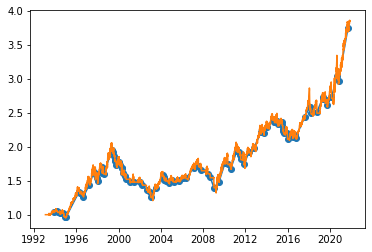

In [7]:
plt.plot(dates, np.cumprod(1+np.array(pnls)),'-o')
plt.plot(unrlzd_dates,np.cumprod(1+np.array(unrlzd)))

Now, we can calculate the risk-adjusted return (Sharpe ratio) with the unrealized PnLs. This value is "annualized" by multiplication with the square root of the trade granularity. In this case we look at daily data, so our number of trading days is approximately 252. Remember, this is not an exact science and purely to get a feel for the strategy's performance.

In [8]:
rar = np.mean(unrlzd)/np.std(unrlzd)*np.sqrt(252)
rar

0.46514031618731383

Next, we calculate the profit per trade using the realized PnLs.

In [9]:
ppt = np.mean(pnls)
ppt

0.015386533972243101

Now, we calculate the average holding period for our trades.

In [10]:
hold_days = np.array(hold_times)/86400
np.mean(hold_days)

71.74509803921569

We need to create some dataframes for strategy returns and PnL to make the calculation of drawdown and beta easier.

In [11]:
df_rets = pd.DataFrame(unrlzd, index=unrlzd_dates)
df_pnl = (1+df_rets).cumprod()

Now we can calculate the drawdown and visualize it in an "underwater plot"

Note the use of "expanding", which, unlike the static window in "rolling", creates a window that expands with time.

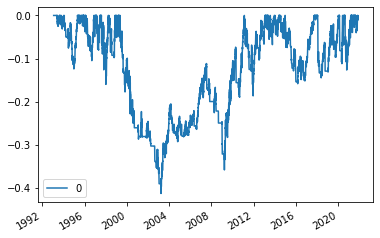

In [12]:
(df_pnl/df_pnl.expanding().max()-1).plot()

Beta can be a useful metric to see how different our strategy is from a buy-and-hold strategy of the underlying asset. 

In [13]:
beta = np.corrcoef(spy.pct_change().iloc[2:],df_rets[0].iloc[2:])[0,1]
beta

0.6074236409717851

Given these metrics we conclude that our strategy is probably not fit for live trading and more research needs to be done to find something better.

### TA-Lib

The Technical Analysis Library is a useful tool for creating technical indicators and chart patterns. It is written in C++ with a Python wrapper. We first need to install it on the Colab server using the code below.

In [15]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3741    0  3741    0     0  18160      0 --:--:-- --:--:-- --:--:-- 18160
100  503k  100  503k    0     0  1041k      0 --:--:-- --:--:-- --:--:-- 1996k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3737    0  3737    0     0  22648      0 --:--:-- --:--:-- --:--:-- 22648
100  406k  100  406k    0     0   733k      0 --:--:-- --:--:-- --:--:-- 59000


Now, we can replicate the moving average calculations from above.

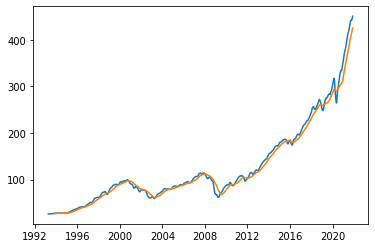

In [16]:
ma50 = talib.SMA(spy,50)
ma200 = talib.SMA(spy,200)
plt.plot(ma50)
plt.plot(ma200)

TA-Lib has much more on offer. Let's explore it:

In [23]:
dir(talib)

['ACOS',
 'AD',
 'ADD',
 'ADOSC',
 'ADX',
 'ADXR',
 'APO',
 'AROON',
 'AROONOSC',
 'ASIN',
 'ATAN',
 'ATR',
 'AVGPRICE',
 'BBANDS',
 'BETA',
 'BOP',
 'CCI',
 'CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CD

Functions starting with CDL indicate candlestick patterns. Descriptions of what they are can be found on Investopedia. Here, we use the 3BlackCrows pattern.

When the pattern occurs in the chart we get a signal of 100 for a bullish pattern and -100 for a bearish pattern.

In [17]:
crows = talib.CDL3BLACKCROWS(df.Open,df.High,df.Low,df.Close)

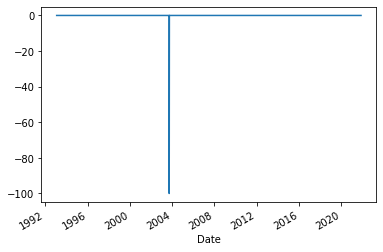

In [18]:
crows.plot()